In [1]:
from preprocessing.pre_process_utils import CDCPArgumentationDoc
from utils.data_processors import ArgMinRelClassProcessorCDCPRBERTJointLearning, ArgMinRelClassProcessorCDCPWithDistance
from transformers import BertTokenizer
from utils.metrics import compute_metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd

data_dir = os.path.join(os.getcwd(), "data/cdcp/original")

# doc_ids = [file.split('.')[0] for file in os.listdir(data_dir) if file.split(".")[-1] == "txt"]
# docs = [CDCPArgumentationDoc(data_dir + '/' + doc_id) for doc_id in doc_ids]

In [2]:
rbert_output_dir = os.path.join(os.getcwd(), "output/bert-rbert-jl-2+None+cdcp_relclass_rbert_jl+512+LR2e-5+WD0+FZ0+EP20+BS8")

tokenizer = BertTokenizer.from_pretrained(
    rbert_output_dir,
    do_lower_case=True,
    cache_dir=None,
)
tokenizer.add_special_tokens({"additional_special_tokens": ['<src>', '</src>', '<trg>', '</trg>']})

dp = ArgMinRelClassProcessorCDCPRBERTJointLearning()
docs = dp.read_cdcp_docs(os.path.join(data_dir, 'test'))

longest_example = 0
counts = {'reason': 0,
          'evidence': 0,
          'noRel': 0,
          'policy': 0, 'fact': 0, 'testimony': 0, 'value': 0, 'reference': 0}

text_info = []
rows = []
skipped_idxs = []

count = 0
for doc_id, doc in enumerate(docs):
    for c_src_idx, c_src in enumerate(doc.prop_offsets):
        for c_trg_idx, c_trg in enumerate(doc.prop_offsets):
            if c_src_idx == c_trg_idx:
                continue
            count += 1
            if (c_src_idx, c_trg_idx) in doc.links_lists['locate']:
                rel_type = doc.links_lists['link'][doc.links_lists['locate'].index((c_src_idx, c_trg_idx))]
            else:
                rel_type = 'noRel'
            c_text_order = [['src', c_src], ['trg', c_trg]] if c_src_idx < c_trg_idx else [['trg', c_trg], ['src', c_src]]
            text_a = dp.create_text_with_tags(doc.raw_text, c_text_order)
            tokens = tokenizer.tokenize(text_a)
            if len(tokens) > 512:
                skipped_idxs.append(count)
                continue
            for prop_idx, prop in enumerate(doc.prop_offsets):
                counts[doc.prop_labels[prop_idx]] += 1
            counts[rel_type] += 1

            source_first = c_src_idx < c_trg_idx
            relation_label = dp.get_labels().index('__label__' + rel_type)
            source_label = dp.get_component_labels().index(doc.prop_labels[c_src_idx])
            target_label = dp.get_component_labels().index(doc.prop_labels[c_trg_idx])
            source_len = tokens.index(dp.TAGS['src'][1].strip()) - tokens.index(dp.TAGS['src'][0].strip())
            target_len = tokens.index(dp.TAGS['trg'][1].strip()) - tokens.index(dp.TAGS['trg'][0].strip())
            distance = abs(c_trg_idx - c_src_idx)
            doc_len = len(tokens)
            bridge_len = tokens.index(dp.TAGS['trg'][0].strip()) - tokens.index(dp.TAGS['src'][1].strip()) - 1 \
                if source_first else tokens.index(dp.TAGS['src'][0].strip()) - tokens.index(dp.TAGS['trg'][1].strip()) - 1
            non_component_token_len = doc_len - source_len - target_len
            outer_len = non_component_token_len - bridge_len
            non_component_percentage = non_component_token_len / doc_len * 100

            row_dict = {'source_first': source_first,
                        'relation_label': relation_label,
                        'source_label': source_label,
                        'target_label': target_label,
                        'source_len': source_len,
                        'target_len': target_len,
                        'Component Distance': distance,
                        'Document Length': doc_len,
                        'Bridge Length': bridge_len,
                        'Non-component Length': non_component_token_len,
                        'Non-component %': non_component_percentage,
                        'Outer Length': outer_len,
                        'document_id': doc_id}

            text_entry = {'text': text_a,
                          'tokens': tokens,
                          'document_id': doc_id,
                          'relation_label': relation_label}
            rows.append(row_dict)
            text_info.append(text_entry)

examples_df = pd.DataFrame(rows)

In [3]:
rbert_relation_preds = []
rbert_source_preds = []
rbert_target_preds = []

output_eval_file = os.path.join(rbert_output_dir, "eval_relation_preds.txt")
with open(output_eval_file, "r") as reader:
    for p in reader:
        for p_label in list(p):
            rbert_relation_preds.append(int(p_label))

output_eval_file = os.path.join(rbert_output_dir, "eval_source_preds.txt")
with open(output_eval_file, "r") as reader:
    for p in reader:
        for p_label in list(p):
            rbert_source_preds.append(int(p_label))

output_eval_file = os.path.join(rbert_output_dir, "eval_target_preds.txt")
with open(output_eval_file, "r") as reader:
    for p in reader:
        for p_label in list(p):
            rbert_target_preds.append(int(p_label))

df = examples_df.copy()

df['rbert_relation_pred'] = np.array(rbert_relation_preds)
df['rbert_source_pred'] = np.array(rbert_source_preds)
df['rbert_target_pred'] = np.array(rbert_target_preds)

In [4]:
dist_output_dir = os.path.join(os.getcwd(), "output/bert-distance+2FC-RelU+cdcp_relclass_distance+166+LR1e-5+WD0+FZ0+EP15+BS20")

dist_relation_preds = []

output_eval_file = os.path.join(dist_output_dir, "eval_relation_preds.txt")
with open(output_eval_file, "r") as reader:
    for p in reader:
        for idx, p_label in enumerate(list(p)):
            if idx in skipped_idxs:
                continue
            dist_relation_preds.append(int(p_label))

df['dist_relation_pred'] = np.array(dist_relation_preds)

In [5]:
rbert_metrics = compute_metrics('cdcp_relclass_resnet_jl', df['rbert_relation_pred'], df['relation_label'])
dist_metrics = compute_metrics('cdcp_relclass_resnet_jl', df['dist_relation_pred'], df['relation_label'])

c:\users\cyrus\.virtualenvs\medical_transformer\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\cyrus\.virtualenvs\medical_transformer\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\cyrus\.virtualenvs\medical_transformer\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

(array([  62.,  336.,  630.,  618.,  334.,  594., 1158.,  624.,  692.,
         364.,    0.,  672., 1056., 1082.,  506.]),
 array([ 19. ,  50.4,  81.8, 113.2, 144.6, 176. , 207.4, 238.8, 270.2,
        301.6, 333. , 364.4, 395.8, 427.2, 458.6, 490. ]),
 <BarContainer object of 15 artists>)

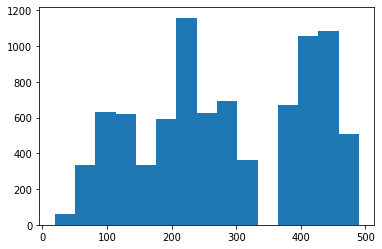

In [6]:
plt.hist(df['Document Length'], bins=15)

In [7]:
rsn = df.loc[df['relation_label'] == 1]

rbert_rsn_tp = df[(df['relation_label'] == 1) & (df['rbert_relation_pred'] == 1)]
rbert_rsn_tn = df[(df['relation_label'] != 1) & (df['rbert_relation_pred'] != 1)]
rbert_rsn_fp = df[(df['relation_label'] == 1) & (df['rbert_relation_pred'] != 1)]
rbert_rsn_fn = df[(df['relation_label'] != 1) & (df['rbert_relation_pred'] == 1)]
rbert_rsn_fp_fn = df[((df['relation_label'] == 1) & (df['rbert_relation_pred'] != 1)) | ((df['relation_label'] != 1) & (df['rbert_relation_pred'] == 1))]
rbert_rsn_tp_tn = df[((df['relation_label'] == 1) & (df['rbert_relation_pred'] == 1)) | ((df['relation_label'] != 1) & (df['rbert_relation_pred'] != 1))]

c:\users\cyrus\.virtualenvs\medical_transformer\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass display_labels=['None', 'Reason', 'Evidence'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


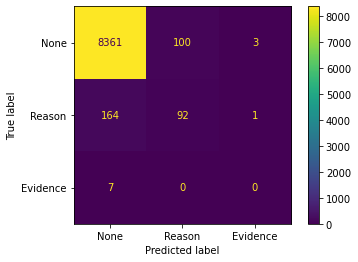

In [8]:
cm = confusion_matrix(df['relation_label'], df['rbert_relation_pred'])

disp = ConfusionMatrixDisplay(cm, ['None', 'Reason', 'Evidence'])

disp.plot()

disp.figure_.savefig('images/RBERT-cm')

c:\users\cyrus\.virtualenvs\medical_transformer\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass display_labels=['None', 'Reason', 'Evidence'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


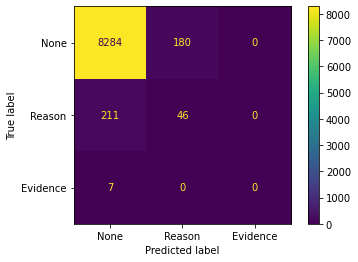

In [9]:
cm2 = confusion_matrix(df['relation_label'], df['dist_relation_pred'])

disp2 = ConfusionMatrixDisplay(cm2, ['None', 'Reason', 'Evidence'])

disp2.plot()

disp2.figure_.savefig('images/DIST-cm')

In [10]:
rbert_rsn_c = rsn[rsn['rbert_relation_pred'] == 1]
rbert_rsn_f = rsn[rsn['rbert_relation_pred'] != 1]

In [11]:
df['relation_label'].value_counts()

0    8464
1     257
2       7
Name: relation_label, dtype: int64

In [12]:
def process_means(dframe, name):
    all_comps = np.concatenate([dframe['source_len'].values, dframe['target_len'].values])
    dframe_mean = pd.Series(dframe.mean()[:], name=name)
    dframe_mean['count'] = len(dframe)
    dframe_mean['component_len'] = all_comps.mean()
    dframe_mean['component_len_std'] = all_comps.std()
    to_drop = ['rbert_relation_pred', 'rbert_source_pred', 'rbert_target_pred', 'dist_relation_pred', 'source_label',
               'target_label', 'relation_label', 'document_id']
    dframe_mean = dframe_mean.drop(to_drop)
    to_std = ['Bridge Length', 'Document Length', 'Non-component Length', 'Outer Length', 'Component Distance', 'Non-component %']
    stds = dframe[to_std].std()
    stds = stds.rename({to_std[i]: to_std[i] + " Std" for i in range(6)})
    dframe_mean = dframe_mean.append(stds)

    # vcs = dframe['source_label'].value_counts(sort=False).reindex(df.source_label.unique(), fill_value=0)
    # vcs = vcs / dframe_mean['count']
    # vcs = vcs.rename({i: dp.get_component_labels()[i] for i in range(5)})
    # dframe_mean.append(vcs).rename(name)
    order = ['source_first', 'source_len', 'target_len', 'component_len', 'component_len_std', 'Document Length', 'Document Length Std',
             'Bridge Length', 'Bridge Length Std', 'Component Distance', 'Component Distance Std',
             'Non-component Length', 'Non-component Length Std', 'Outer Length', 'Outer Length Std',
             'Non-component %', 'Non-component % Std', 'count']
    dframe_mean = dframe_mean.reindex(index = order)
    return dframe_mean.rename(name)

process_means(rsn, 'All Reason')

source_first                  0.295720
source_len                   22.824903
target_len                   19.085603
component_len                20.955253
component_len_std            14.216774
Document Length             191.054475
Document Length Std         112.313165
Bridge Length                11.369650
Bridge Length Std            26.656516
Component Distance            1.669261
Component Distance Std        1.554840
Non-component Length        149.143969
Non-component Length Std    114.745399
Outer Length                137.774319
Outer Length Std            116.157169
Non-component %              69.046642
Non-component % Std          21.749564
count                       257.000000
Name: All Reason, dtype: float64

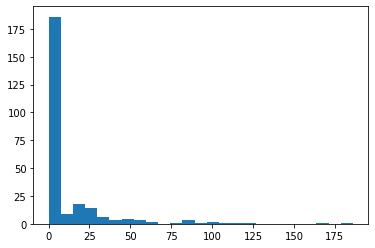

In [13]:
plt.hist(rsn['Bridge Length'], bins=25)

# rsn_mean = pd.Series(rsn.mean()[:], name='All Reason')
# rsn_mean['count'] = len(rsn)
rsn_mean = process_means(rsn, 'All Reason')

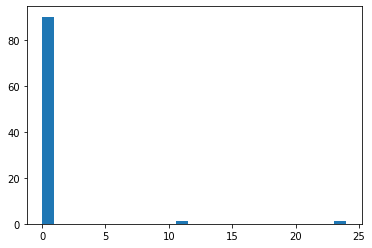

In [14]:
plt.hist(rbert_rsn_c['Bridge Length'], bins=25)

rbert_rsn_c_mean = process_means(rbert_rsn_c, 'Correct Reason RBERT')

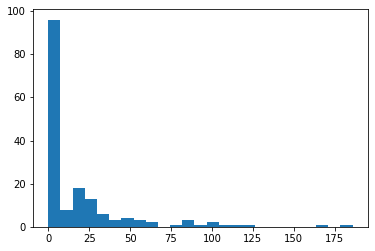

In [15]:
plt.hist(rbert_rsn_f['Bridge Length'], bins=25)

rbert_rsn_f_mean = process_means(rbert_rsn_f, 'False Reason RBERT')

In [16]:
dist_rsn_c = rsn[rsn['dist_relation_pred'] == 1]
dist_rsn_f = rsn[rsn['dist_relation_pred'] != 1]

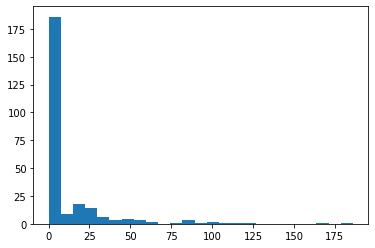

In [17]:
plt.hist(rsn['Bridge Length'], bins=25)

dist_rsn_c_mean = process_means(dist_rsn_c, 'Correct Reason DIST')

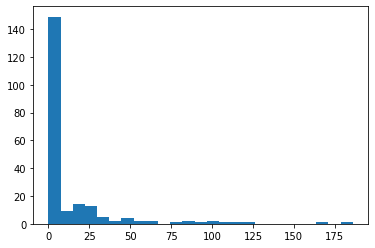

In [18]:
plt.hist(dist_rsn_f['Bridge Length'], bins=25)

dist_rsn_f_mean = process_means(dist_rsn_f, 'False Reason DIST')

In [19]:
means = pd.DataFrame(rsn_mean)
means = means.join(rbert_rsn_c_mean)
means = means.join(rbert_rsn_f_mean)
means = means.join(dist_rsn_c_mean)
means = means.join(dist_rsn_f_mean)
means = means.round(2)

means

,All Reason,Correct Reason RBERT,False Reason RBERT,Correct Reason DIST,False Reason DIST
source_first,0.30,0.29,0.30,0.35,0.28
source_len,22.82,21.89,23.35,21.67,23.08
target_len,19.09,18.39,19.47,19.80,18.93
component_len,20.96,20.14,21.41,20.74,21.00
component_len_std,14.22,10.81,15.78,11.31,14.77
Document Length,191.05,166.47,204.76,173.96,194.78
Document Length Std,112.31,103.25,115.09,115.45,111.55
Bridge Length,11.37,0.38,17.50,6.98,12.33
Bridge Length Std,26.66,2.74,31.61,16.84,28.29
Component Distance,1.67,1.02,2.03,1.41,1.73


In [20]:
df

,source_first,relation_label,source_label,target_label,source_len,target_len,Component Distance,Document Length,Bridge Length,Non-component Length,Non-component %,Outer Length,document_id,rbert_relation_pred,rbert_source_pred,rbert_target_pred,dist_relation_pred
0,True,0,1,3,26,16,1,81,0,39,48.148148,39,0,1,1,3,0
1,True,0,1,0,26,38,2,81,15,17,20.987654,2,0,1,1,0,1
2,False,0,3,1,16,26,1,81,0,39,48.148148,39,0,0,3,1,0
3,True,1,3,0,16,38,1,81,0,27,33.333333,27,0,1,3,0,0
4,False,0,0,1,38,26,2,81,15,17,20.987654,2,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8723,True,0,4,3,15,21,2,55,17,19,34.545455,2,149,0,4,0,0
8724,False,0,3,4,18,15,1,55,0,22,40.000000,22,149,0,3,4,0
8725,True,0,3,3,18,21,1,55,0,16,29.090909,16,149,0,3,0,0
8726,False,0,3,4,21,15,2,55,17,19,34.545455,2,149,0,0,4,0


No handles with labels found to put in legend.


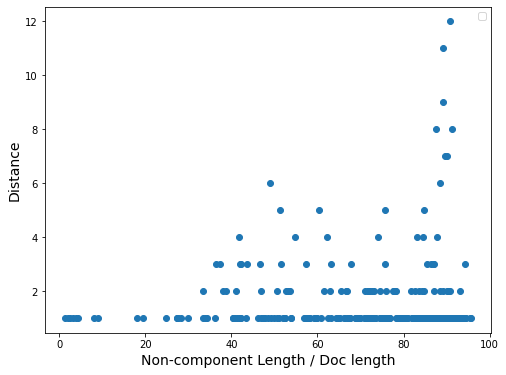

In [21]:
stat = 'Non-component %'
bins = 15
data1 = df[(df['relation_label'] == 1)][stat]
data2 = df[(df['relation_label'] == 1)]['Component Distance']
bins = np.histogram(np.hstack((data1, data2)), bins=bins)[1]
title = 'Non-component / doc length - Reason: Correct predictions against all examples'

plt.figure(figsize=(8,6))
plt.scatter(data1, data2)

# plt.hist(df[df['relation_label'] == 1][stat], bins=bins, alpha=0.5, label="Reason")
plt.xlabel("Non-component Length / Doc length", size=14)
plt.ylabel("Distance", size=14)
# plt.title(title)
plt.legend(loc='upper right')
# plt.savefig('images/RBERT-NCOT')



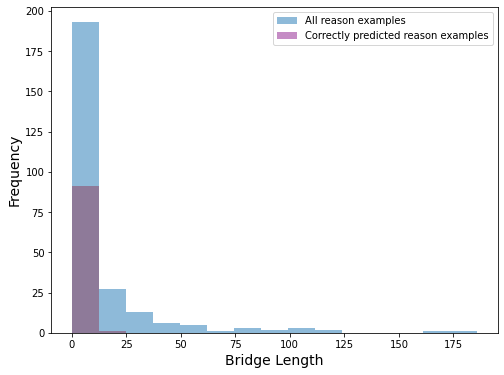

In [22]:
stat = 'Bridge Length'
bins = 15
data1 = df[(df['relation_label'] == 1) & (df['rbert_relation_pred'] == 1)][stat]
data2 = df[(df['relation_label'] == 1)][stat]
bins = np.histogram(np.hstack((data1, data2)), bins=bins)[1]
title = 'Bridge length - Reason: Correct predictions against all examples'


plt.figure(figsize=(8,6))
plt.hist(data1, bins=bins, alpha=0.5, color='red')
plt.hist(data2, bins=bins, alpha=0.5, label="All reason examples")
plt.hist(data2[0:0], bins=bins, alpha=0.45, label="Correctly predicted reason examples", color='purple')
# plt.hist(df[df['relation_label'] == 1][stat], bins=bins, alpha=0.5, label="Reason")
plt.xlabel("Bridge Length", size=14)
plt.ylabel("Frequency", size=14)
# plt.title(title)
plt.legend(loc='upper right')
plt.savefig('images/RBERT-BL')

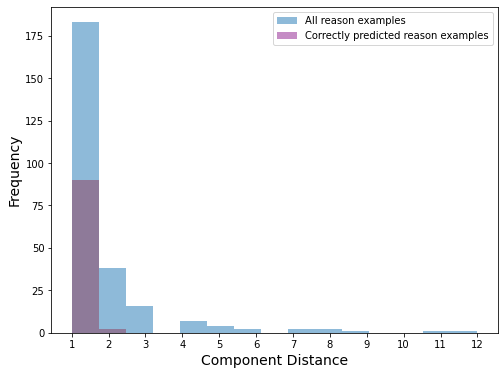

In [23]:
stat = 'Component Distance'
bins = 15
data1 = df[(df['relation_label'] == 1) & (df['rbert_relation_pred'] == 1)][stat]
data2 = df[(df['relation_label'] == 1)][stat]
bins = np.histogram(np.hstack((data1, data2)), bins=bins)[1]
title = 'Component Distance - Reason: Correct predictions against all examples'


plt.figure(figsize=(8,6))
plt.hist(data1, bins=bins, alpha=0.5, color='red')
plt.hist(data2, bins=bins, alpha=0.5, label="All reason examples")
plt.hist(data2[0:0], bins=bins, alpha=0.45, label="Correctly predicted reason examples", color='purple')
# plt.hist(df[df['relation_label'] == 1][stat], bins=bins, alpha=0.5, label="Reason")
plt.xlabel("Component Distance", size=14)
plt.ylabel("Frequency", size=14)
plt.xticks([x + 1  for x in range(12)])
# plt.title(title)
plt.legend(loc='upper right')
plt.savefig('images/RBERT-CD')

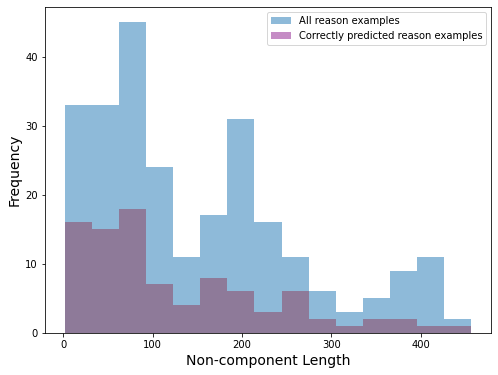

In [24]:
stat = 'Non-component Length'
bins = 15
data1 = df[(df['relation_label'] == 1) & (df['rbert_relation_pred'] == 1)][stat]
data2 = df[(df['relation_label'] == 1)][stat]
bins = np.histogram(np.hstack((data1, data2)), bins=bins)[1]
title = 'Non-component length - Reason: Correct predictions against all examples'

plt.figure(figsize=(8,6))
plt.hist(data1, bins=bins, alpha=0.5, color='red')
plt.hist(data2, bins=bins, alpha=0.5, label="All reason examples")
plt.hist(data2[0:0], bins=bins, alpha=0.45, label="Correctly predicted reason examples", color='purple')

# plt.hist(df[df['relation_label'] == 1][stat], bins=bins, alpha=0.5, label="Reason")
plt.xlabel("Non-component Length", size=14)
plt.ylabel("Frequency", size=14)
# plt.title(title)
plt.legend(loc='upper right')
plt.savefig('images/RBERT-NCL')

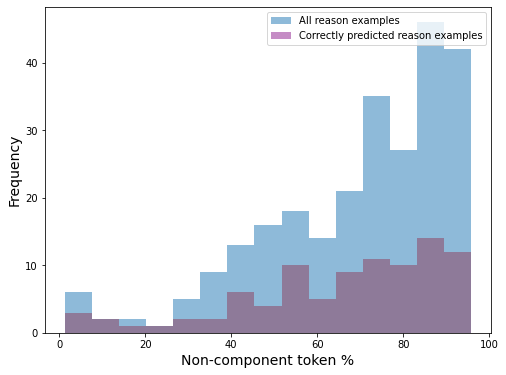

In [25]:
stat = 'Non-component %'
bins = 15
data1 = df[(df['relation_label'] == 1) & (df['rbert_relation_pred'] == 1)][stat]
data2 = df[(df['relation_label'] == 1)][stat]
bins = np.histogram(np.hstack((data1, data2)), bins=bins)[1]
title = 'Proportion of non-component tokens - Reason: Correct predictions against all examples'

plt.figure(figsize=(8,6))
plt.hist(data1, bins=bins, alpha=0.5, color='red')
plt.hist(data2, bins=bins, alpha=0.5, label="All reason examples")
plt.hist(data2[0:0], bins=bins, alpha=0.45, label="Correctly predicted reason examples", color='purple')

# plt.hist(df[df['relation_label'] == 1][stat], bins=bins, alpha=0.5, label="Reason")
plt.xlabel("Non-component token %", size=14)
plt.ylabel("Frequency", size=14)
# plt.title(title)
plt.legend(loc='upper right')
plt.savefig('images/RBERT-NCOT')

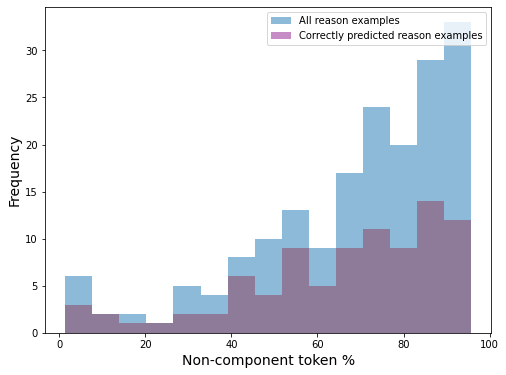

In [26]:
stat = 'Non-component %'
bins = 15
data1 = df[(df['relation_label'] == 1) & (df['rbert_relation_pred'] == 1) & (df['Component Distance'] == 1)][stat]
data2 = df[(df['relation_label'] == 1) & (df['Component Distance'] == 1)][stat]
bins = np.histogram(np.hstack((data1, data2)), bins=bins)[1]
title = 'Proportion of non-component tokens - Reason: Correct predictions against all examples'

plt.figure(figsize=(8,6))
plt.hist(data1, bins=bins, alpha=0.5, color='red')
plt.hist(data2, bins=bins, alpha=0.5, label="All reason examples")
plt.hist(data2[0:0], bins=bins, alpha=0.45, label="Correctly predicted reason examples", color='purple')

# plt.hist(df[df['relation_label'] == 1][stat], bins=bins, alpha=0.5, label="Reason")
plt.xlabel("Non-component token %", size=14)
plt.ylabel("Frequency", size=14)
# plt.title(title)
plt.legend(loc='upper right')
plt.savefig('images/RBERT-NCOT-D1')

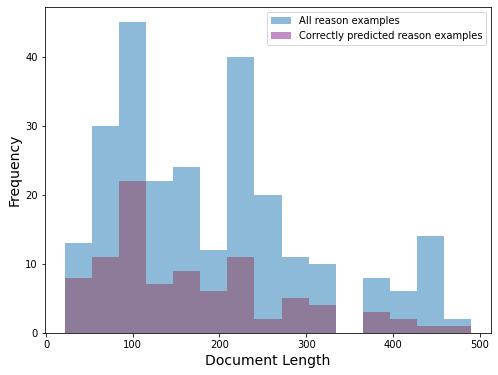

In [27]:
stat = 'Document Length'
bins = 15
data1 = df[(df['relation_label'] == 1) & (df['rbert_relation_pred'] == 1)][stat]
data2 = df[(df['relation_label'] == 1)][stat]
bins = np.histogram(np.hstack((data1, data2)), bins=bins)[1]
title = 'Document length - Reason: Correct predictions against all examples'

plt.figure(figsize=(8,6))
plt.hist(data1, bins=bins, alpha=0.5, color='red')
plt.hist(data2, bins=bins, alpha=0.5, label="All reason examples")
plt.hist(data2[0:0], bins=bins, alpha=0.45, label="Correctly predicted reason examples", color='purple')
# plt.hist(df[df['relation_label'] == 1][stat], bins=bins, alpha=0.5, label="Reason")
plt.xlabel("Document Length", size=14)
plt.ylabel("Frequency", size=14)
# plt.title(title)
plt.legend(loc='upper right')
plt.savefig('images/RBERT-DL')

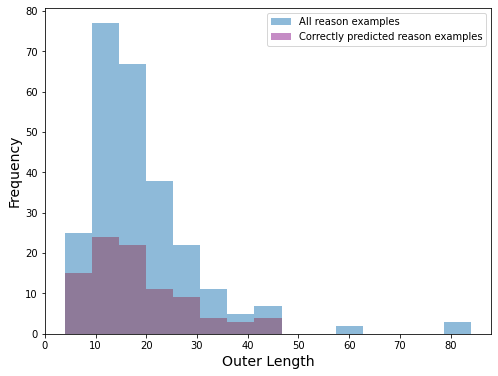

In [28]:
stat = 'target_len'
bins = 15
data1 = df[(df['relation_label'] == 1) & (df['rbert_relation_pred'] == 1)][stat]
data2 = df[(df['relation_label'] == 1)][stat]
bins = np.histogram(np.hstack((data1, data2)), bins=bins)[1]
title = 'Outer length - Reason: Correct predictions against all examples'

plt.figure(figsize=(8,6))
plt.hist(data1, bins=bins, alpha=0.5, color='red')
plt.hist(data2, bins=bins, alpha=0.5, label="All reason examples")
plt.hist(data2[0:0], bins=bins, alpha=0.45, label="Correctly predicted reason examples", color='purple')
# plt.hist(df[df['relation_label'] == 1][stat], bins=bins, alpha=0.5, label="Reason")
plt.xlabel("Outer Length", size=14)
plt.ylabel("Frequency", size=14)
# plt.title(title)
plt.legend(loc='upper right')
plt.savefig('images/RBERT-OL')

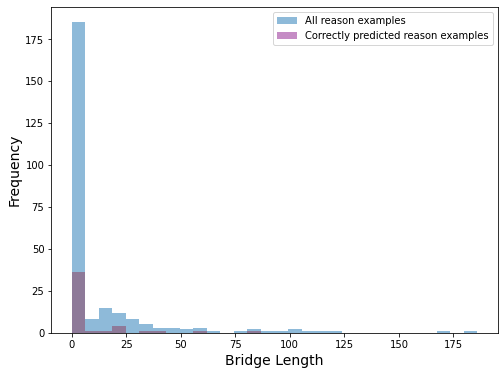

In [29]:
stat = 'Bridge Length'
bins = 30
data1 = df[(df['relation_label'] == 1) & (df['dist_relation_pred'] == 1)][stat]
data2 = df[(df['relation_label'] == 1)][stat]
bins = np.histogram(np.hstack((data1, data2)), bins=bins)[1]
title = 'DIST \n Bridge length - Reason: Correct predictions against all examples'

plt.figure(figsize=(8,6))
plt.hist(data1, bins=bins, alpha=0.5, color='red')
plt.hist(data2, bins=bins, alpha=0.5, label="All reason examples")
plt.hist(data2[0:0], bins=bins, alpha=0.45, label="Correctly predicted reason examples", color='purple')
# plt.hist(df[df['relation_label'] == 1][stat], bins=bins, alpha=0.5, label="Reason")
plt.xlabel("Bridge Length", size=14)
plt.ylabel("Frequency", size=14)
# plt.title(title)
plt.legend(loc='upper right')
plt.savefig('images/DIST-BL')

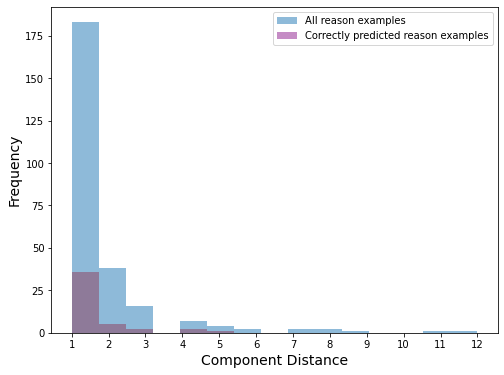

In [30]:
stat = 'Component Distance'
bins = 15
data1 = df[(df['relation_label'] == 1) & (df['dist_relation_pred'] == 1)][stat]
data2 = df[(df['relation_label'] == 1)][stat]
bins = np.histogram(np.hstack((data1, data2)), bins=bins)[1]
title = 'DIST \n Component Distance - Reason: Correct predictions against all examples'


plt.figure(figsize=(8,6))
plt.hist(data1, bins=bins, alpha=0.5, color='red')
plt.hist(data2, bins=bins, alpha=0.5, label="All reason examples")
plt.hist(data2[0:0], bins=bins, alpha=0.45, label="Correctly predicted reason examples", color='purple')
# plt.hist(df[df['relation_label'] == 1][stat], bins=bins, alpha=0.5, label="Reason")
plt.xlabel("Component Distance", size=14)
plt.ylabel("Frequency", size=14)
plt.xticks([x + 1  for x in range(12)])
# plt.title(title)
plt.legend(loc='upper right')
plt.savefig('images/DIST-CD')

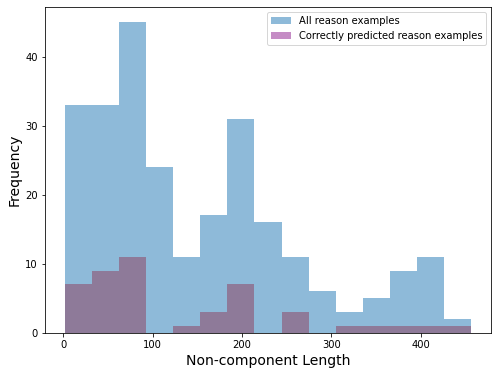

In [31]:
stat = 'Non-component Length'
bins = 15
data1 = df[(df['relation_label'] == 1) & (df['dist_relation_pred'] == 1)][stat]
data2 = df[(df['relation_label'] == 1)][stat]
bins = np.histogram(np.hstack((data1, data2)), bins=bins)[1]
title = 'DIST \n Non-component length - Reason: Correct predictions against all examples'

plt.figure(figsize=(8,6))
plt.hist(data1, bins=bins, alpha=0.5, color='red')
plt.hist(data2, bins=bins, alpha=0.5, label="All reason examples")
plt.hist(data2[0:0], bins=bins, alpha=0.45, label="Correctly predicted reason examples", color='purple')
# plt.hist(df[df['relation_label'] == 1][stat], bins=bins, alpha=0.5, label="Reason")
plt.xlabel("Non-component Length", size=14)
plt.ylabel("Frequency", size=14)
# plt.title(title)
plt.legend(loc='upper right')
plt.savefig('images/DIST-NCL')

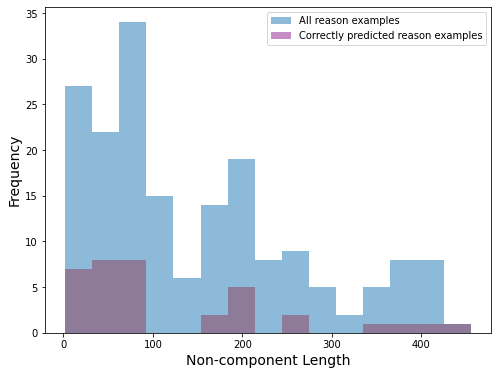

In [32]:
stat = 'Non-component Length'
bins = 15
data1 = df[(df['relation_label'] == 1) & (df['dist_relation_pred'] == 1) & (df['Component Distance'] == 1)][stat]
data2 = df[(df['relation_label'] == 1) & (df['Component Distance'] == 1)][stat]
bins = np.histogram(np.hstack((data1, data2)), bins=bins)[1]
title = 'DIST \n Non-component length - Reason: Correct predictions against all examples'

plt.figure(figsize=(8,6))
plt.hist(data1, bins=bins, alpha=0.5, color='red')
plt.hist(data2, bins=bins, alpha=0.5, label="All reason examples")
plt.hist(data2[0:0], bins=bins, alpha=0.45, label="Correctly predicted reason examples", color='purple')
# plt.hist(df[df['relation_label'] == 1][stat], bins=bins, alpha=0.5, label="Reason")
plt.xlabel("Non-component Length", size=14)
plt.ylabel("Frequency", size=14)
# plt.title(title)
plt.legend(loc='upper right')
plt.savefig('images/DIST-NCL-D1')

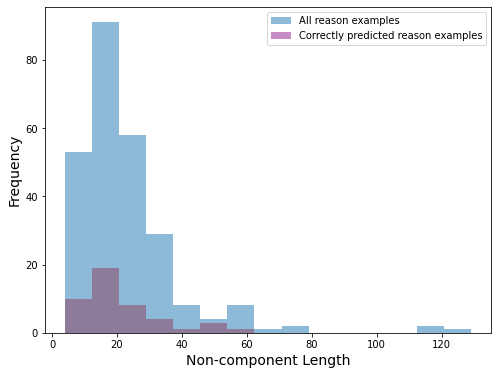

In [33]:
stat = 'source_len'
bins = 15
data1 = df[(df['relation_label'] == 1) & (df['dist_relation_pred'] == 1)][stat]
data2 = df[(df['relation_label'] == 1)][stat]
bins = np.histogram(np.hstack((data1, data2)), bins=bins)[1]
title = 'DIST \n Non-component length - Reason: Correct predictions against all examples'

plt.figure(figsize=(8,6))
plt.hist(data1, bins=bins, alpha=0.5, color='red')
plt.hist(data2, bins=bins, alpha=0.5, label="All reason examples")
plt.hist(data2[0:0], bins=bins, alpha=0.45, label="Correctly predicted reason examples", color='purple')
# plt.hist(df[df['relation_label'] == 1][stat], bins=bins, alpha=0.5, label="Reason")
plt.xlabel("Non-component Length", size=14)
plt.ylabel("Frequency", size=14)
# plt.title(title)
plt.legend(loc='upper right')
plt.savefig('images/DIST-SL')

In [34]:
def plot_proportional_change(stat, verbose=False):
    data1 = df[(df['relation_label'] == 1) & (df['dist_relation_pred'] == 1)][stat]
    data2 = df[(df['relation_label'] == 1)][stat]
    bins = 15

    _, bin1 = pd.cut(data2, bins, retbins=True)
    bins = pd.IntervalIndex.from_breaks(bin1)

    binned_dist = pd.cut(data1, bins)
    bin_vc_dist = binned_dist.value_counts()

    binned_all = pd.cut(data2, bins)
    bin_vc_all = binned_all.value_counts()

    dist_NCP_proportion = (bin_vc_dist / bin_vc_all).fillna(0)

    data3 = df[(df['relation_label'] == 1) & (df['rbert_relation_pred'] == 1)][stat]

    binned_rbert = pd.cut(data3, bins)
    bin_vc_rbert = binned_rbert.value_counts()

    rbert_NCP_proportion = (bin_vc_rbert / bin_vc_all).fillna(0)
    proportion_change = (rbert_NCP_proportion - dist_NCP_proportion) * 100

    midpoints = [(bin1[x] + bin1[x+1]) / 2 for x in range(0, len(bin1) -1 , 1)]

    p_plus = [x for x in proportion_change.values if x >= 0]
    p_neg = [x for x in proportion_change.values if x < 0]
    mid_plus = [midpoints[x] for x, y in enumerate(proportion_change.values) if y >= 0]
    mid_neg = [midpoints[x] for x, y in enumerate(proportion_change.values) if y < 0]

    if verbose:
        print(p_plus)
        print(bin1)
        print((bin1[0] + bin1[1]) / 2)
        print(midpoints)
        print(max(proportion_change.index).right)
        print(len(midpoints))
        print(len(proportion_change))
        print(len(p_plus))
        print(len(mid_plus))
        print(len(p_neg))
        print(len(mid_neg))

    # plt.bar(midpoints, proportion_change, alpha=0.7, width=(max(proportion_change.index).right / len(midpoints)))
    plt.bar(mid_plus, p_plus, alpha=0.7, width=(max(proportion_change.index).right / len(midpoints)))
    plt.bar(mid_neg, p_neg, alpha=0.7, color='red', width=(max(proportion_change.index).right / len(midpoints)))

    plt.axhline(y=0, color='black', linestyle='-')

    # plt.title(stat + " proportional change between RBERT and DIST Correct predictions")
    plt.xlabel(stat, size=14)
    plt.ylabel("%", size=14)
    plt.yticks([ x for x in range(-100, 125, 25)])
    plt.show()

1    29.508197
2    -7.894737
3   -12.500000
4   -28.571429
5   -25.000000
Name: Component Distance, dtype: float64


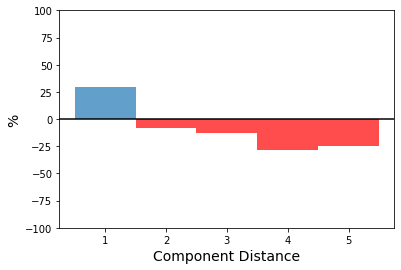

In [35]:
def plot_proportional_change_nobins(stat, verbose=False):
    data1 = df[(df['relation_label'] == 1) & (df['dist_relation_pred'] == 1)][stat]
    data2 = df[(df['relation_label'] == 1)][stat]

    vc_dist = data1.value_counts().sort_index()[0:5]
    vc_all = data2.value_counts().sort_index()[0:5]

    dist_NCP_proportion = (vc_dist / vc_all).fillna(0)

    data3 = df[(df['relation_label'] == 1) & (df['rbert_relation_pred'] == 1)][stat]

    vc_rbert = data3.value_counts().sort_index()[0:5]

    rbert_NCP_proportion = (vc_rbert / vc_all).fillna(0)

    change = (rbert_NCP_proportion - dist_NCP_proportion) * 100

    midpoints = [1,2,3,4,5]

    print(change)

    p_plus = [x for x in change.values if x >= 0]
    p_neg = [x for x in change.values if x < 0]
    mid_plus = [midpoints[x] for x, y in enumerate(change.values) if y >= 0]
    mid_neg = [midpoints[x] for x, y in enumerate(change.values) if y < 0]

    if verbose:
        print(p_plus)
        print(midpoints)
        print(max(change.index).right)
        print(len(midpoints))
        print(len(change))
        print(len(p_plus))
        print(len(mid_plus))
        print(len(p_neg))
        print(len(mid_neg))

    # plt.bar(midpoints, proportion_change, alpha=0.7, width=(max(proportion_change.index).right / len(midpoints)))
    plt.bar(mid_plus, p_plus, alpha=0.7, width=1)
    plt.bar(mid_neg, p_neg, alpha=0.7, color='red', width=1)

    plt.axhline(y=0, color='black', linestyle='-')

    # plt.title(stat + " proportional change between RBERT and DIST Correct predictions")
    plt.xlabel(stat, size=14)
    plt.ylabel("%", size=14)
    plt.xticks([1,2,3,4,5])
    plt.yticks([ x for x in range(-100, 125, 25)])
    # plt.savefig('images/CD-Prop')
    plt.show()

plot_proportional_change_nobins('Component Distance')

In [36]:
def plot_proportional_change_d1(stat, verbose=False):
    data1 = df[(df['relation_label'] == 1) & (df['dist_relation_pred'] == 1) & (df['Component Distance'] == 1)][stat]
    data2 = df[(df['relation_label'] == 1) & (df['Component Distance'] == 1)][stat]
    bins = 15

    _, bin1 = pd.cut(data2, bins, retbins=True)
    bins = pd.IntervalIndex.from_breaks(bin1)

    binned_dist = pd.cut(data1, bins)
    bin_vc_dist = binned_dist.value_counts()

    binned_all = pd.cut(data2, bins)
    bin_vc_all = binned_all.value_counts()

    dist_NCP_proportion = (bin_vc_dist / bin_vc_all).fillna(0)

    data3 = df[(df['relation_label'] == 1) & (df['rbert_relation_pred'] == 1) & (df['Component Distance'] == 1)][stat]

    binned_rbert = pd.cut(data3, bins)
    bin_vc_rbert = binned_rbert.value_counts()

    rbert_NCP_proportion = (bin_vc_rbert / bin_vc_all).fillna(0)
    proportion_change = (rbert_NCP_proportion - dist_NCP_proportion) * 100

    midpoints = [(bin1[x] + bin1[x+1]) / 2 for x in range(0, len(bin1) -1 , 1)]

    p_plus = [x for x in proportion_change.values if x >= 0]
    p_neg = [x for x in proportion_change.values if x < 0]
    mid_plus = [midpoints[x] for x, y in enumerate(proportion_change.values) if y >= 0]
    mid_neg = [midpoints[x] for x, y in enumerate(proportion_change.values) if y < 0]

    if verbose:
        print(p_plus)
        print(bin1)
        print((bin1[0] + bin1[1]) / 2)
        print(midpoints)
        print(max(proportion_change.index).right)
        print(len(midpoints))
        print(len(proportion_change))
        print(len(p_plus))
        print(len(mid_plus))
        print(len(p_neg))
        print(len(mid_neg))

    # plt.bar(midpoints, proportion_change, alpha=0.7, width=(max(proportion_change.index).right / len(midpoints)))
    plt.bar(mid_plus, p_plus, alpha=0.7, width=(max(proportion_change.index).right / len(midpoints)))
    plt.bar(mid_neg, p_neg, alpha=0.7, color='red', width=(max(proportion_change.index).right / len(midpoints)))

    plt.axhline(y=0, color='black', linestyle='-')

    # plt.title(stat + " proportional change between RBERT and DIST Correct predictions")
    plt.xlabel(stat, size=14)
    plt.ylabel("%", size=14)
    plt.yticks([ x for x in range(-100, 125, 25)])
    plt.savefig('images/NCL-Prop')
    plt.show()

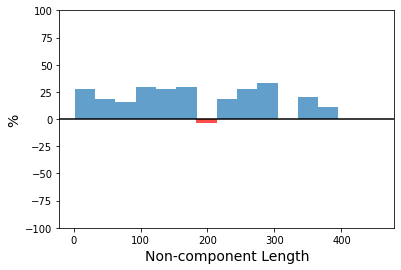

KeyboardInterrupt: 

In [147]:
def plot_net_change(stat, verbose=False):
    data1 = df[(df['relation_label'] == 1) & (df['dist_relation_pred'] == 1)][stat]
    data2 = df[(df['relation_label'] == 1)][stat]
    bins = 15

    _, bin1 = pd.cut(data2, bins, retbins=True)
    bins = pd.IntervalIndex.from_breaks(bin1)

    binned_dist = pd.cut(data1, bins)
    bin_vc_dist = binned_dist.value_counts()

    dist_NCP = bin_vc_dist.fillna(0)

    data3 = df[(df['relation_label'] == 1) & (df['rbert_relation_pred'] == 1)][stat]

    binned_rbert = pd.cut(data3, bins)
    bin_vc_rbert = binned_rbert.value_counts()

    rbert_NCP = (bin_vc_rbert).fillna(0)

    change = rbert_NCP - dist_NCP

    midpoints = [(bin1[x] + bin1[x+1]) / 2 for x in range(0, len(bin1) -1 , 1)]

    p_plus = [x for x in change.values if x >= 0]
    p_neg = [x for x in change.values if x < 0]
    mid_plus = [midpoints[x] for x, y in enumerate(change.values) if y >= 0]
    mid_neg = [midpoints[x] for x, y in enumerate(change.values) if y < 0]

    if verbose:
        print(p_plus)
        print(bin1)
        print((bin1[0] + bin1[1]) / 2)
        print(midpoints)
        print(max(change.index).right)
        print(len(midpoints))
        print(len(change))
        print(len(p_plus))
        print(len(mid_plus))
        print(len(p_neg))
        print(len(mid_neg))

    # plt.bar(midpoints, proportion_change, alpha=0.7, width=(max(proportion_change.index).right / len(midpoints)))
    plt.bar(mid_plus, p_plus, alpha=0.7, width=(max(change.index).right / len(midpoints)))
    plt.bar(mid_neg, p_neg, alpha=0.7, color='red', width=(max(change.index).right / len(midpoints)))

    plt.axhline(y=0, color='black', linestyle='-')

    # plt.title(stat + " net change between RBERT and DIST Correct predictions")
    plt.xlabel(stat, size=14)
    plt.ylabel("Frequency", size=14)
    # plt.yticks([ x / 100 for x in range(-100, 125, 25)])
    plt.show()
    
# plot_proportional_change('Non-component %')
# plot_change('Document Length')
# plot_change('Non-component Length')
# plot_proportional_change('Bridge Length')
# plot_net_change('Bridge Length')
# plot_proportional_change('Component Distance')
# plot_net_change('Component Distance')
# plot_proportional_change('Document Length')
# plot_net_change('Document Length')
# plot_proportional_change('Non-component %')
# plot_net_change('Non-component %')
# plot_proportional_change_d1('Non-component %')

plot_proportional_change('Non-component Length')
plot_net_change('Non-component Length')
plot_proportional_change_d1('Non-component Length')

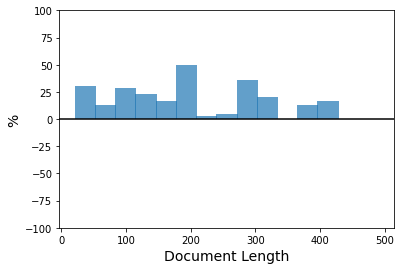

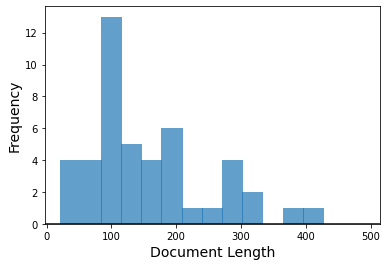

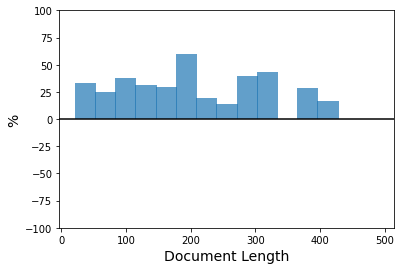

In [38]:
plot_proportional_change('Document Length')
plot_net_change('Document Length')
plot_proportional_change_d1('Document Length')

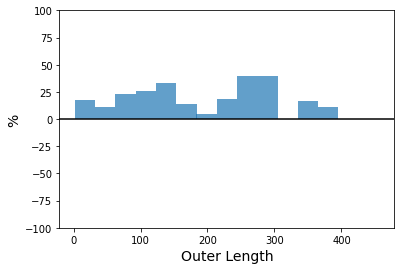

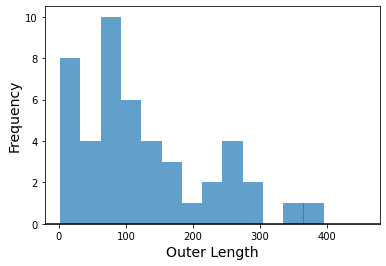

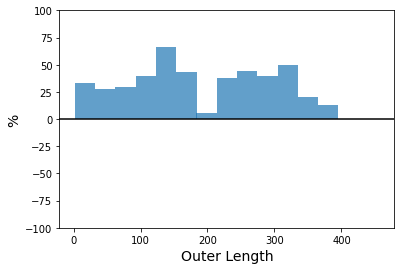

In [39]:
plot_proportional_change('Outer Length')
plot_net_change('Outer Length')
plot_proportional_change_d1('Outer Length')

[ 1.3986014   7.68467165 13.9707419  20.25681215 26.5428824  32.82895266
 39.11502291 45.40109316 51.68716341 57.97323366 64.25930391 70.54537417
 76.83144442 83.11751467 89.40358492 95.68965517]


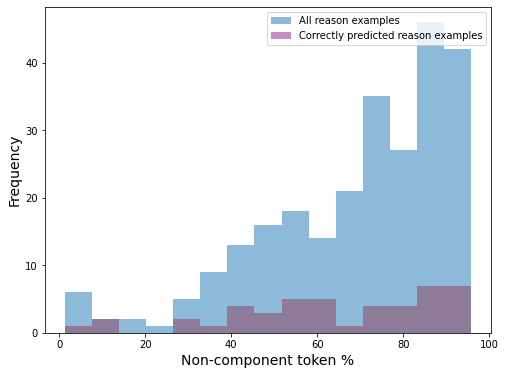

In [40]:
stat = 'Non-component %'
bins = 15
data1 = df[(df['relation_label'] == 1) & (df['dist_relation_pred'] == 1)][stat]
data2 = df[(df['relation_label'] == 1)][stat]
bins = np.histogram(np.hstack((data1, data2)), bins=bins)[1]
title = 'DIST \n Non-component / doc length - Reason: Correct predictions against all examples'
print(bins)
plt.figure(figsize=(8,6))
plt.hist(data1, bins=bins, alpha=0.5, color='red')
plt.hist(data2, bins=bins, alpha=0.5, label="All reason examples")
plt.hist(data2[0:0], bins=bins, alpha=0.45, label="Correctly predicted reason examples", color='purple')

# plt.hist(df[df['relation_label'] == 1][stat], bins=bins, alpha=0.5, label="Reason")
plt.xlabel("Non-component token %", size=14)
plt.ylabel("Frequency", size=14)
# plt.title(title)
plt.legend(loc='upper right')
plt.savefig('images/DIST-NCOT')

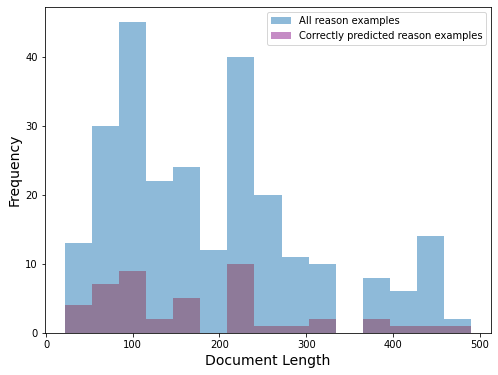

In [41]:
stat = 'Document Length'
bins = 15
data1 = df[(df['relation_label'] == 1) & (df['dist_relation_pred'] == 1)][stat]
data2 = df[(df['relation_label'] == 1)][stat]
bins = np.histogram(np.hstack((data1, data2)), bins=bins)[1]
title = 'DIST \n Document length - Reason: Correct predictions against all examples'

plt.figure(figsize=(8,6))
plt.hist(data1, bins=bins, alpha=0.5, color='red')
plt.hist(data2, bins=bins, alpha=0.5, label="All reason examples")
plt.hist(data2[0:0], bins=bins, alpha=0.45, label="Correctly predicted reason examples", color='purple')

# plt.hist(df[df['relation_label'] == 1][stat], bins=bins, alpha=0.5, label="Reason")
plt.xlabel("Document Length", size=14)
plt.ylabel("Frequency", size=14)
# plt.title(title)
plt.legend(loc='upper right')
plt.savefig('images/DIST-DL')

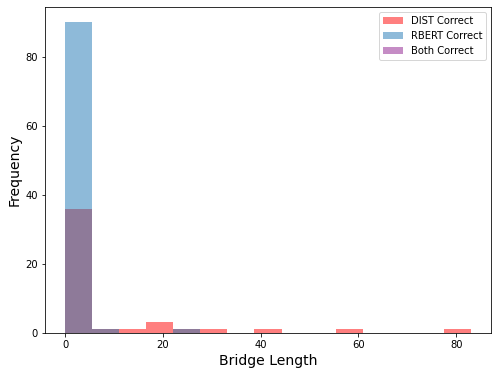

In [42]:
stat = 'Bridge Length'
bins = 15
data1 = df[(df['relation_label'] == 1) & (df['dist_relation_pred'] == 1)][stat]
data2 = df[(df['relation_label'] == 1) & (df['rbert_relation_pred'] == 1)][stat]
bins = np.histogram(np.hstack((data1, data2)), bins=bins)[1]
title = 'DIST vs Bridge length - Reason: Correct predictions'

plt.figure(figsize=(8,6))
plt.hist(data1, bins=bins, alpha=0.5, label="DIST Correct", color='red')
plt.hist(data2, bins=bins, alpha=0.5, label="RBERT Correct")
plt.hist(data2[0:0], bins=bins, alpha=0.45, label="Both Correct", color='purple')
# plt.hist(df[df['relation_label'] == 1][stat], bins=bins, alpha=0.5, label="Reason")
plt.xlabel("Bridge Length", size=14)
plt.ylabel("Frequency", size=14)
# plt.title(title)
plt.legend(loc='upper right')
plt.savefig('images/RBERTvDIST-BL')

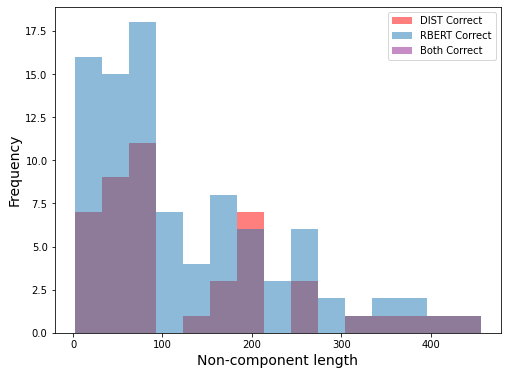

In [43]:
stat = 'Non-component Length'
bins = 15
data1 = df[(df['relation_label'] == 1) & (df['dist_relation_pred'] == 1)][stat]
data2 = df[(df['relation_label'] == 1) & (df['rbert_relation_pred'] == 1)][stat]
bins = np.histogram(np.hstack((data1, data2)), bins=bins)[1]
title = 'DIST vs Non-component length - Reason: Correct predictions'

plt.figure(figsize=(8,6))
plt.hist(data1, bins=bins, alpha=0.5, label="DIST Correct", color='red')
plt.hist(data2, bins=bins, alpha=0.5, label="RBERT Correct")
plt.hist(data2[0:0], bins=bins, alpha=0.45, label="Both Correct", color='purple')
# plt.hist(df[df['relation_label'] == 1][stat], bins=bins, alpha=0.5, label="Reason")
plt.xlabel("Non-component length", size=14)
plt.ylabel("Frequency", size=14)
# plt.title(title)
plt.legend(loc='upper right')
plt.savefig('images/RBERTvDIST-NCL')

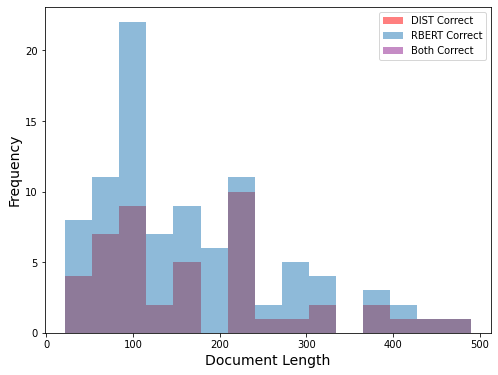

In [44]:
stat = 'Document Length'
bins = 15
data1 = df[(df['relation_label'] == 1) & (df['dist_relation_pred'] == 1)][stat]
data2 = df[(df['relation_label'] == 1) & (df['rbert_relation_pred'] == 1)][stat]
bins = np.histogram(np.hstack((data1, data2)), bins=bins)[1]
title = 'DIST vs Document length - Reason: Correct predictions'

plt.figure(figsize=(8,6))
plt.hist(data1, bins=bins, alpha=0.5, label="DIST Correct", color='red')
plt.hist(data2, bins=bins, alpha=0.5, label="RBERT Correct")
plt.hist(data2[0:0], bins=bins, alpha=0.45, label="Both Correct", color='purple')

# plt.hist(df[df['relation_label'] == 1][stat], bins=bins, alpha=0.5, label="Reason")
plt.xlabel("Document Length", size=14)
plt.ylabel("Frequency", size=14)
# plt.title(title)
plt.legend(loc='upper right')
plt.savefig('images/RBERTvDIST-DL')

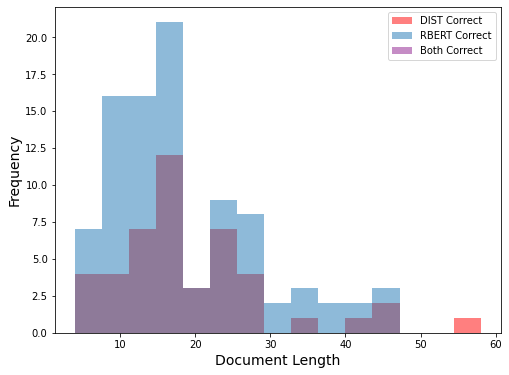

In [45]:
stat = 'target_len'
bins = 15
data1 = df[(df['relation_label'] == 1) & (df['dist_relation_pred'] == 1)][stat]
data2 = df[(df['relation_label'] == 1) & (df['rbert_relation_pred'] == 1)][stat]
bins = np.histogram(np.hstack((data1, data2)), bins=bins)[1]
title = 'DIST vs Document length - Reason: Correct predictions'

plt.figure(figsize=(8,6))
plt.hist(data1, bins=bins, alpha=0.5, label="DIST Correct", color='red')
plt.hist(data2, bins=bins, alpha=0.5, label="RBERT Correct")
plt.hist(data2[0:0], bins=bins, alpha=0.45, label="Both Correct", color='purple')

# plt.hist(df[df['relation_label'] == 1][stat], bins=bins, alpha=0.5, label="Reason")
plt.xlabel("Document Length", size=14)
plt.ylabel("Frequency", size=14)
# plt.title(title)
plt.legend(loc='upper right')

In [46]:
# stat = 'Bridge Length'
# data1 = df[df['relation_label'] == df['rbert_relation_pred']][stat]
# data2 = df[df['relation_label'] != df['rbert_relation_pred']][stat]
# bins = 25
# bins = np.histogram(np.hstack((data1, data2)), bins=bins)[1]
# title = 'Bridge length of correct/incorrect rbert predictions (All)'
#
# plt.figure(figsize=(8,6))
# plt.hist(data1, bins=bins, alpha=0.5, label="Correct")
# plt.hist(data2, bins=bins, alpha=0.5, label="False")
# plt.xlabel("Bridge Length", size=14)
# plt.ylabel("Frequency", size=14)
# # plt.title(title)
# plt.legend(loc='upper right')

In [47]:
# stat = 'Non-component Length'
# bins = 20
# data1 = df[(df['relation_label'] == 1) & (df['rbert_relation_pred'] == 1)][stat]
# data2 = df[(df['relation_label'] == 1) & (df['rbert_relation_pred'] != 1)][stat]
# bins = np.histogram(np.hstack((data1, data2)), bins=bins)[1]
# title = 'Non component token length of correct/incorrect rbert predictions'
#
# plt.figure(figsize=(8,6))
# plt.hist(data1, bins=bins, alpha=0.5, label="Correct Reason")
# plt.hist(data2, bins=bins, alpha=0.5, label="False Reason")
# # plt.hist(df[df['relation_label'] == 1][stat], bins=bins, alpha=0.5, label="Reason")
# plt.xlabel("Bridge Length", size=14)
# plt.ylabel("Frequency", size=14)
# # plt.title(title)
# plt.legend(loc='upper right')


In [48]:
# stat = 'Document Length'
# bins = 20
# data1 = df[(df['relation_label'] == 1) & (df['rbert_relation_pred'] == 1)][stat]
# data2 = df[(df['relation_label'] == 1) & (df['rbert_relation_pred'] != 1)][stat]
# bins = np.histogram(np.hstack((data1, data2)), bins=bins)[1]
# title = 'Non component token length of correct/incorrect rbert predictions'
#
# plt.figure(figsize=(8,6))
# plt.hist(data1, bins=bins, alpha=0.5, label="Correct Reason")
# plt.hist(data2, bins=bins, alpha=0.5, label="False Reason")
# # plt.hist(df[df['relation_label'] == 1][stat], bins=bins, alpha=0.5, label="Reason")
# plt.xlabel("Document token length", size=14)
# plt.ylabel("Frequency", size=14)
# # plt.title(title)
# plt.legend(loc='upper right')

In [49]:
len(data1)

46

source_first                  0.290323
source_len                   22.387097
target_len                   19.903226
component_len                21.145161
component_len_std            10.318863
Document Length             142.322581
Document Length Std         106.394670
Bridge Length                 0.000000
Bridge Length Std             0.000000
Component Distance            1.000000
Component Distance Std        0.000000
Non-component Length        100.032258
Non-component Length Std    106.095706
Outer Length                100.032258
Outer Length Std            106.095706
Non-component %              56.664110
Non-component % Std          24.859806
count                        31.000000
Name: Both Correct, dtype: float64

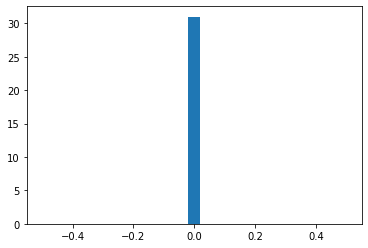

In [50]:
# Common correct preds
rsn_dist_c_rbert_c = rsn[(rsn['dist_relation_pred'] == 1) & (rsn['rbert_relation_pred'] == 1)]

plt.hist(rsn_dist_c_rbert_c['Bridge Length'], bins=25)

rsn_dist_c_rbert_c_mean = process_means(rsn_dist_c_rbert_c, 'Both Correct')

rsn_dist_c_rbert_c_mean

In [51]:
# Common incorrect preds
rsn_dist_f_rbert_f = rsn[(rsn['dist_relation_pred'] != 1) & (rsn['rbert_relation_pred'] != 1)]
# rsn_dist_f_rbert_f_mean = pd.Series(rsn_dist_f_rbert_f.mean()[:], name='Both Incorrect')
# rsn_dist_f_rbert_f_mean['count'] = len(rsn_dist_f_rbert_f)
rsn_dist_f_rbert_f_mean = process_means(rsn_dist_f_rbert_f, 'Both Incorrect')

rsn_dist_f_rbert_c = rsn[(rsn['dist_relation_pred'] != 1) & (rsn['rbert_relation_pred'] == 1)]
# rsn_dist_f_rbert_c_mean = pd.Series(rsn_dist_f_rbert_c.mean()[:], name='RBERT not Dist')
# rsn_dist_f_rbert_c_mean['count'] = len(rsn_dist_f_rbert_c)
rsn_dist_f_rbert_c_mean = process_means(rsn_dist_f_rbert_c, 'RBERT not Dist')

rsn_dist_c_rbert_f = rsn[(rsn['dist_relation_pred'] == 1) & (rsn['rbert_relation_pred'] != 1)]
# rsn_dist_c_rbert_f_mean = pd.Series(rsn_dist_c_rbert_f.mean()[:], name='Dist not RBERT')
# rsn_dist_c_rbert_f_mean['count'] = len(rsn_dist_c_rbert_f)
rsn_dist_c_rbert_f_mean = process_means(rsn_dist_c_rbert_f, 'Dist not RBERT')

means2 = pd.DataFrame(rsn_mean)
means2 = means2.join(rsn_dist_c_rbert_c_mean)
means2 = means2.join(rsn_dist_f_rbert_f_mean)
means2 = means2.join(rsn_dist_f_rbert_c_mean)
means2 = means2.join(rsn_dist_c_rbert_f_mean)
means2 = means2.round(2)

means2


,All Reason,Both Correct,Both Incorrect,RBERT not Dist,Dist not RBERT
source_first,0.30,0.29,0.28,0.30,0.47
source_len,22.82,22.39,23.66,21.64,20.20
target_len,19.09,19.90,19.46,17.62,19.60
component_len,20.96,21.15,21.56,19.63,19.90
component_len_std,14.22,10.32,16.02,11.01,13.08
Document Length,191.05,142.32,201.31,178.74,239.33
Document Length Std,112.31,106.39,115.50,100.28,108.57
Bridge Length,11.37,0.00,17.11,0.57,21.40
Bridge Length Std,26.66,0.00,32.31,3.36,24.10
Component Distance,1.67,1.00,2.01,1.03,2.27


In [52]:
rsn_dist_c_rbert_c

,source_first,relation_label,source_label,target_label,source_len,target_len,Component Distance,Document Length,Bridge Length,Non-component Length,Non-component %,Outer Length,document_id,rbert_relation_pred,rbert_source_pred,rbert_target_pred,dist_relation_pred
137,False,1,1,0,20,22,1,217,0,175,80.645161,175,8,1,1,0,1
291,False,1,3,3,12,28,1,95,0,55,57.894737,55,15,1,1,1,1
299,False,1,3,3,29,26,1,95,0,40,42.105263,40,15,1,3,3,1
1253,False,1,2,0,29,33,1,153,0,91,59.477124,91,30,1,2,0,1
1494,True,1,3,0,27,19,1,72,0,26,36.111111,26,36,1,3,0,1
1654,False,1,1,0,23,14,1,51,0,14,27.450980,14,42,1,2,0,1
1862,False,1,1,3,21,8,1,114,0,85,74.561404,85,50,1,3,3,1
2461,False,1,2,3,39,23,1,64,0,2,3.125000,2,59,1,2,3,1
2630,True,1,3,0,51,15,1,318,0,252,79.245283,252,60,1,3,0,1
3141,False,1,3,3,19,17,1,123,0,87,70.731707,87,64,1,3,3,1


In [53]:
for idx in rsn_dist_c_rbert_c.index:
    print('Doc ID: {}'.format(text_info[idx]['document_id']))
    print(text_info[idx]['text'])
    print(text_info[idx]['tokens'])
    print('-------------------------')
    print()

Doc ID: 8
My company calls, auto-dials, emails, and snail mails customers many times before they are sent to a collection agency. Many debtors simply refuse to respond to the original debtor. They only make payment after the account is assigned to a collection agency -- akin to seeing just how far they can go before there's a consequence to not making payment. <trg>  Requiring a validation notice from the owner of the debt should be optional on the creditor's part. </trg>  <src>  The FDCPA requires the collection agency to send their first notice after the debt is assigned. </src>  More notices from the creditor are useless and expensive. And the single most frequently used excuse of any debtor is "I didn't receive the letter/invoice/statement". A first class letter costs $0.55 minimum (inclusive of postage, paper, and envelope). That cost does not include overhead and employee cost. Multiply that cost by the number of notices and statements already sent (and ignored) and you begin to 

In [54]:
for idx in rsn_dist_f_rbert_f.index:
    print('Doc ID: {}'.format(text_info[idx]['document_id']))
    print(text_info[idx]['text'])
    print(text_info[idx]['tokens'])
    print('-------------------------')
    print()

Doc ID: 4
If the present mortgage repayment debacle is any indication of noticing or added noticing I think it is much simpler to notify the consumer whom to pay and list the original creditor name. Also, I think it would be a good idea for CFPB and the industry to combine this with FCRA issues. <src>  For example, if a consumer today reviews their credit reports the normal term is "sold to another lender" but no name. </src>  I have heard similar stories from attorneys who try to match what a consumer lists as a creditor versus what is listed in a credit report. <trg>  Seems to me that everyone is trying to close the back door but leaving the front door open. </trg> 
['if', 'the', 'present', 'mortgage', 'repay', '##ment', 'de', '##ba', '##cle', 'is', 'any', 'indication', 'of', 'noticing', 'or', 'added', 'noticing', 'i', 'think', 'it', 'is', 'much', 'simpler', 'to', 'not', '##ify', 'the', 'consumer', 'whom', 'to', 'pay', 'and', 'list', 'the', 'original', 'credit', '##or', 'name', '.', 

In [55]:
both_correct_docs = set(rsn_dist_c_rbert_c['document_id'].values)
both_incorrect_docs = set(rsn_dist_f_rbert_f['document_id'].values)

both_correct_docs.intersection(both_incorrect_docs)

{8, 30, 50, 60, 64, 84, 92, 93, 112, 130, 142, 145, 148}

In [56]:
both_correct_docs.difference(both_incorrect_docs)

{15, 36, 42, 59, 71, 79, 98, 104, 111, 119, 139, 140, 143, 147}

In [57]:
rbert_correct = set(rbert_rsn_c['document_id'].values)
dist_correct = set(dist_rsn_c['document_id'].values)

bi = both_incorrect_docs.copy()
bi.difference_update(rbert_correct)
bi.difference_update(dist_correct)
bi

{4,
 5,
 6,
 12,
 14,
 22,
 28,
 38,
 53,
 58,
 61,
 62,
 67,
 74,
 77,
 86,
 88,
 89,
 90,
 91,
 100,
 101,
 102,
 107,
 108,
 110,
 115,
 121,
 127,
 136,
 141}

In [58]:
bi

{4,
 5,
 6,
 12,
 14,
 22,
 28,
 38,
 53,
 58,
 61,
 62,
 67,
 74,
 77,
 86,
 88,
 89,
 90,
 91,
 100,
 101,
 102,
 107,
 108,
 110,
 115,
 121,
 127,
 136,
 141}

In [59]:
count = 0
for text in text_info:
    if text['document_id'] in bi and text['relation_label'] == 1:
        print(text['text'])
        print(text['tokens'])
        print('-------------------------')
        print()
        count += 1

If the present mortgage repayment debacle is any indication of noticing or added noticing I think it is much simpler to notify the consumer whom to pay and list the original creditor name. Also, I think it would be a good idea for CFPB and the industry to combine this with FCRA issues. <src>  For example, if a consumer today reviews their credit reports the normal term is "sold to another lender" but no name. </src>  I have heard similar stories from attorneys who try to match what a consumer lists as a creditor versus what is listed in a credit report. <trg>  Seems to me that everyone is trying to close the back door but leaving the front door open. </trg> 
['if', 'the', 'present', 'mortgage', 'repay', '##ment', 'de', '##ba', '##cle', 'is', 'any', 'indication', 'of', 'noticing', 'or', 'added', 'noticing', 'i', 'think', 'it', 'is', 'much', 'simpler', 'to', 'not', '##ify', 'the', 'consumer', 'whom', 'to', 'pay', 'and', 'list', 'the', 'original', 'credit', '##or', 'name', '.', 'also', ',

In [160]:
adj_200 = rsn[(rsn['Component Distance']) == 1
                                      & (rsn['Non-component Length'] >= 183.6)
                                      & (rsn['Non-component Length'] <= 213.86667)
                                      & (rsn['relation_label'] != rsn['rbert_relation_pred'])]
process_means(adj_200, 'adj200')
adj_200

,source_first,relation_label,source_label,target_label,source_len,target_len,Component Distance,Document Length,Bridge Length,Non-component Length,Non-component %,Outer Length,document_id,rbert_relation_pred,rbert_source_pred,rbert_target_pred,dist_relation_pred
1738,True,1,2,2,9,22,1,235,0,204,86.808511,204,47,0,2,2,1
3378,False,1,3,3,21,21,1,232,0,190,81.896552,190,73,0,3,3,0
3389,False,1,3,3,9,21,1,232,0,202,87.068966,202,73,0,3,3,0
4771,False,1,3,3,32,16,1,242,0,194,80.165289,194,78,0,3,3,0
4787,True,1,1,3,21,10,1,242,0,211,87.190083,211,78,0,3,3,0
4922,True,1,3,0,10,22,1,242,0,210,86.776860,210,78,0,3,0,1
5084,True,1,3,0,10,7,1,215,0,198,92.093023,198,80,0,3,0,1
5351,False,1,2,3,23,12,1,236,0,201,85.169492,201,83,0,2,3,0
5917,False,1,1,1,26,28,1,258,0,204,79.069767,204,89,0,3,1,0
6233,False,1,3,3,21,14,1,224,0,189,84.375000,189,96,0,3,3,0


In [122]:
for doc_id in dist_long_correct_ids:
    print(rbert_rsn_c[rbert_rsn_c['document_id'] == doc_id].index)

Int64Index([137], dtype='int64')
Int64Index([137], dtype='int64')
Int64Index([2503, 2630], dtype='int64')
Int64Index([3117, 3124, 3141, 3165], dtype='int64')
Int64Index([], dtype='int64')
Int64Index([4956, 4960], dtype='int64')
Int64Index([5418, 5549, 5593], dtype='int64')
Int64Index([6783], dtype='int64')
Int64Index([7785, 7786, 7799], dtype='int64')
Int64Index([8572, 8631, 8661, 8691], dtype='int64')


In [104]:
rbert_rsn_c.iloc[3138]

IndexError: single positional indexer is out-of-bounds

In [80]:
count = 0
for text in text_info:
    if text['document_id'] in bi and text['relation_label'] == 1:
        print(text['text'])
        print(text['tokens'])
        print('-------------------------')
        print()
        count += 1

KeyboardInterrupt: 

In [60]:
print(count)

52


In [61]:
text_info['document_id' == 2]

{'text': " <src> Recently, courts have held that debt collectors can escape 1692i's venue provisions entirely by pursuing debt collection through arbitration instead. </src>  <trg>  As the NAF studies reflect, arbitration has not proven a satisfactory alternative. </trg>  I urge the CFPB to include in a rule language interpreting 1692i as requiring debt collectors to proceed in court, not through largely-unregulated arbitral forums.",
 'tokens': ['<src>',
  'recently',
  ',',
  'courts',
  'have',
  'held',
  'that',
  'debt',
  'collectors',
  'can',
  'escape',
  '1692',
  '##i',
  "'",
  's',
  'venue',
  'provisions',
  'entirely',
  'by',
  'pursuing',
  'debt',
  'collection',
  'through',
  'arbitration',
  'instead',
  '.',
  '</src>',
  '<trg>',
  'as',
  'the',
  'na',
  '##f',
  'studies',
  'reflect',
  ',',
  'arbitration',
  'has',
  'not',
  'proven',
  'a',
  'satisfactory',
  'alternative',
  '.',
  '</trg>',
  'i',
  'urge',
  'the',
  'cf',
  '##p',
  '##b',
  'to',


In [62]:
incorrect = set(df[df['relation_label'] != df['rbert_relation_pred']]['document_id'])
correct = set(df[df['relation_label'] == df['rbert_relation_pred']]['document_id'])

incorrect.difference(correct)

set()

In [140]:
rbert_rsn_c.sort_values('Non-component Length')

,source_first,relation_label,source_label,target_label,source_len,target_len,Component Distance,Document Length,Bridge Length,Non-component Length,Non-component %,Outer Length,document_id,rbert_relation_pred,rbert_source_pred,rbert_target_pred,dist_relation_pred
6745,False,1,1,3,13,7,1,22,0,2,9.090909,2,111,1,1,3,1
301,False,1,1,0,72,23,1,97,0,2,2.061856,2,16,1,1,0,0
303,False,1,2,3,61,17,1,80,0,2,2.500000,2,17,1,2,3,0
2461,False,1,2,3,39,23,1,64,0,2,3.125000,2,59,1,2,3,1
8511,False,1,3,3,19,4,1,25,0,2,8.000000,2,147,1,3,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5549,False,1,3,0,16,5,1,366,0,345,94.262295,345,84,1,1,0,0
4651,False,1,3,0,21,13,1,413,0,379,91.767554,379,75,1,3,0,0
4519,False,1,3,3,15,10,1,413,0,388,93.946731,388,75,1,3,3,0
762,True,1,2,2,31,16,1,451,0,404,89.578714,404,25,1,2,2,0


In [130]:
rsn[rsn['document_id'] == 8]

,source_first,relation_label,source_label,target_label,source_len,target_len,Component Distance,Document Length,Bridge Length,Non-component Length,Non-component %,Outer Length,document_id,rbert_relation_pred,rbert_source_pred,rbert_target_pred,dist_relation_pred
137,False,1,1,0,20,22,1,217,0,175,80.645161,175,8,1,1,0,1
144,False,1,3,0,12,22,2,217,19,183,84.331797,164,8,0,3,0,1
158,False,1,3,0,60,22,4,217,58,135,62.211982,77,8,0,3,0,1
160,False,1,3,3,60,12,2,217,28,145,66.820276,117,8,0,3,3,0


In [126]:
text_info[7531]['text']

"One communication from the debt collector per week is plenty. On top of that, The debt collector's phone rep should have power over the autodialer in the following way. A consumer's number is on the screen, the report log on that number is on the screen, the most current info at the top of the screen. If the debt collector phone rep sees that the very last communication does is already updated (such as waiting on a job interview with a date that is still in the future), then the debt collector phone rep should have the power to prevent the auto dialer from making the call. <trg>  Not only does this prevent unnecessary hounding of the customer, it also helps prevent abusive reactions from consumers towards the debt collector phone rep </trg>  <src>  because the consumer recalls their last communication and that what was discussed could not have reasonably happened yet. </src> "

In [135]:
text_info[144]['text']

'My company calls, auto-dials, emails, and snail mails customers many times before they are sent to a collection agency. Many debtors simply refuse to respond to the original debtor. They only make payment after the account is assigned to a collection agency -- akin to seeing just how far they can go before there\'s a consequence to not making payment. <trg>  Requiring a validation notice from the owner of the debt should be optional on the creditor\'s part. </trg>  The FDCPA requires the collection agency to send their first notice after the debt is assigned. <src>  More notices from the creditor are useless and expensive. </src>  And the single most frequently used excuse of any debtor is "I didn\'t receive the letter/invoice/statement". A first class letter costs $0.55 minimum (inclusive of postage, paper, and envelope). That cost does not include overhead and employee cost. Multiply that cost by the number of notices and statements already sent (and ignored) and you begin to see th

In [136]:
text_info[158]['text']

'My company calls, auto-dials, emails, and snail mails customers many times before they are sent to a collection agency. Many debtors simply refuse to respond to the original debtor. They only make payment after the account is assigned to a collection agency -- akin to seeing just how far they can go before there\'s a consequence to not making payment. <trg>  Requiring a validation notice from the owner of the debt should be optional on the creditor\'s part. </trg>  The FDCPA requires the collection agency to send their first notice after the debt is assigned. More notices from the creditor are useless and expensive. And the single most frequently used excuse of any debtor is "I didn\'t receive the letter/invoice/statement". <src>  A first class letter costs $0.55 minimum (inclusive of postage, paper, and envelope). That cost does not include overhead and employee cost. Multiply that cost by the number of notices and statements already sent (and ignored) and you begin to see the true c

In [137]:
text_info[160]['text']

'My company calls, auto-dials, emails, and snail mails customers many times before they are sent to a collection agency. Many debtors simply refuse to respond to the original debtor. They only make payment after the account is assigned to a collection agency -- akin to seeing just how far they can go before there\'s a consequence to not making payment. Requiring a validation notice from the owner of the debt should be optional on the creditor\'s part. The FDCPA requires the collection agency to send their first notice after the debt is assigned. <trg>  More notices from the creditor are useless and expensive. </trg>  And the single most frequently used excuse of any debtor is "I didn\'t receive the letter/invoice/statement". <src>  A first class letter costs $0.55 minimum (inclusive of postage, paper, and envelope). That cost does not include overhead and employee cost. Multiply that cost by the number of notices and statements already sent (and ignored) and you begin to see the true c

In [144]:
text_info[8238]['text']

'I appreciate Mr. Bartmann\'s comments but they appear to be grounded in a collection agency perspective  (there is always business and market share tension between collection agencies and law firms). The reality is that (and this was voiced by other participants) many (not all but many) debtors simply won\'t/can\'t pay until they have to. The FDCPA and TCPA have truly made communications with debtor both difficult and hazardous for the collector. For instance, the fact that you can\'t safely leave a voice message for a debtor should be very troubling. Over the years, our firm has stopped initial outbound calling (responding only to inbound calls) and also limited our pre-suit letters to just two. We send the required disclosure letter and (there being no response and the account reviewed for suit) then send a discounted payment offer that says we are going to file suit but would rather settle. We offer reasonable terms to the debtors to avoid a costly suit but  the response rate is ab

In [161]:
text_info[4771]['text']

'Email communication is a huge advantage for all involved parties. <trg>  Emails provide consumers with much better tools to control how they are being contacted. </trg>  <src>  First, if treating emails as "in writing" (as they should), disputing a debt or demanding that collectors cease communication is much easier. </src>  Second, setting rules to hide collection notices is a powerful tool not available in any other communication medium. 3rd party disclosure is therefore a lesser concern. Third, email delivery is fast, and facilitates an efficient process, where less communications can be made to reach a settlement. Everything is in writing. Fourth, email is significantly less confrontational than phone calls  and causes much less stress to recipients. Fifth, email is better than recording in keeping record of communication, making it even harder for collectors to hide acts of non compliance. Email should be allowed, while keeping the sensitive parts of the message (disclosures, per

In [162]:
text_info[4787]['text']

'Email communication is a huge advantage for all involved parties. Emails provide consumers with much better tools to control how they are being contacted. First, if treating emails as "in writing" (as they should), disputing a debt or demanding that collectors cease communication is much easier. <src>  Second, setting rules to hide collection notices is a powerful tool not available in any other communication medium. </src>  <trg>  3rd party disclosure is therefore a lesser concern. </trg>  Third, email delivery is fast, and facilitates an efficient process, where less communications can be made to reach a settlement. Everything is in writing. Fourth, email is significantly less confrontational than phone calls  and causes much less stress to recipients. Fifth, email is better than recording in keeping record of communication, making it even harder for collectors to hide acts of non compliance. Email should be allowed, while keeping the sensitive parts of the message (disclosures, per

In [163]:
text_info[4922]['text']

'Email communication is a huge advantage for all involved parties. Emails provide consumers with much better tools to control how they are being contacted. First, if treating emails as "in writing" (as they should), disputing a debt or demanding that collectors cease communication is much easier. Second, setting rules to hide collection notices is a powerful tool not available in any other communication medium. 3rd party disclosure is therefore a lesser concern. Third, email delivery is fast, and facilitates an efficient process, where less communications can be made to reach a settlement. Everything is in writing. Fourth, email is significantly less confrontational than phone calls  and causes much less stress to recipients. Fifth, email is better than recording in keeping record of communication, making it even harder for collectors to hide acts of non compliance. Email should be allowed, while keeping the sensitive parts of the message (disclosures, personal details etc) hidden - as